# Phi2 Model for Sentiment Analysis

The code imports the os module and sets two environment variables:

* CUDA_VISIBLE_DEVICES: This environment variable tells PyTorch which GPUs to use. In this case, the code is setting the environment variable to 0, which means that PyTorch will use the first GPU.
import os


* TOKENIZERS_PARALLELISM: This environment variable tells the Hugging Face Transformers library whether to parallelize the tokenization process. In this case, the code is setting the environment variable to false, which means that the tokenization process will not be parallelized.

-> os.environ["CUDA_VISIBLE_DEVICES"] = "0"
-> os.environ["TOKENIZERS_PARALLELISM"] = "false"


* You do this when you are sharing the GPU and you have the limited resources to work with. But in my case I am utilising the full power

## Package Installation

In [1]:
!pip install -qU \
     accelerate \
     peft \
     einops \
     datasets \
     bitsandbytes \
     trl \
     transformers \
     datasets \
     plotly \
     tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!nvidia-smi

Thu Jun 26 22:01:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

%env TRANSFORMERS_VERBOSITY=info


2025-06-26 22:01:17.634241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750975277.776837      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750975277.823727      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


env: TRANSFORMERS_VERBOSITY=info


In [4]:
# Load the CSV file
df = pd.read_csv('/kaggle/input/financial-dataset/all-data 1 1.csv',
                 names=["sentiment", "text"],
                 encoding="utf-8", encoding_errors="replace")
df

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [5]:
df.shape

(4846, 2)

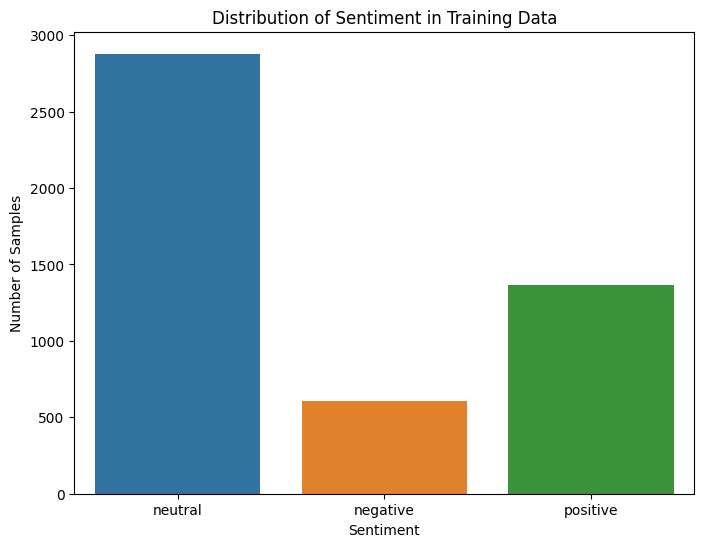

In [6]:

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiment in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Number of Samples')
plt.show()

In the context of fine-tuning a powerful, pre-trained Large Language Model (LLM) like Phi-2, it is common to use a smaller training set than in traditional machine learning. The primary goal is not to teach the model from scratch, but rather to adapt its vast, pre-existing knowledge to a new, specific task. Because the model is already so capable, a relatively small and high-quality fine-tuning dataset is often sufficient to achieve a significant performance improvement. The choice in the tutorial to use a 900-sample training set was a practical decision to ensure the process is fast and accessible on resource-constrained hardware, while still being large enough to demonstrate the effectiveness of fine-tuning. A similarly sized test set was kept to ensure the final performance evaluation was reliable and statistically meaningful.

In [7]:
X_train = list()
X_test = list()

for sentiment in ["positive", "negative", "neutral"]:
  train, test = train_test_split(
      df[df.sentiment == sentiment],
      train_size=400,
      test_size=200,
      random_state=42
  )

  X_train.append(train)
  X_test.append(test)

X_train = pd.concat(X_train).sample(frac=1, random_state=42)
X_test = pd.concat(X_test)

eval_idx = [idx for idx in df.index if idx not in list(train.index) + list(test.index)]
X_eval = df[df.index.isin(eval_idx)]

X_validaiton = (X_eval.groupby('sentiment', group_keys=False).apply(lambda x:x.sample(n=50, random_state=10, replace=True)))
X_train = X_train.reset_index(drop=True)

/tmp/ipykernel_19/2987005424.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_validaiton = (X_eval.groupby('sentiment', group_keys=False).apply(lambda x:x.sample(n=50, random_state=10, replace=True)))


In [8]:
X_train.shape

(1200, 2)

In [9]:
df.sentiment.value_counts()

sentiment
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64

In [10]:
X_validaiton['sentiment'].groupby(X_validaiton['sentiment']).count()

sentiment
negative    50
neutral     50
positive    50
Name: sentiment, dtype: int64

In [11]:
def generate_prompt(data_point):
  prompt = f"""The sentiment of the following phrase: '{data_point["text"]}' is
            \n\n Positive
            \n Negative
            \n Neutral
            \n Cannot be determined
            \n\nSolution: The correct option is {data_point["sentiment"]}""".strip()

  return prompt

def generate_test_prompt(data_point):
    prompt =  f"""The sentiment of the following phrase: '{data_point["text"]}' is
            \n\n Positive
            \n Negative
            \n Neutral
            \n Cannot be determined
            \n\nSolution: The correct option is""".strip()
    return prompt

X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1),
                       columns = ['text'])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1),
                      columns=['text'])
y_test = X_test.sentiment
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1),
                      columns=['text'])

**The code `Dataset.from_pandas()` is converting your data from a Pandas DataFrame into a `Dataset` object from the Hugging Face `datasets` library**

---

### 1. Efficiency and Memory Management (The Most Important Reason)

This is the biggest difference between the two formats.

* **Pandas DataFrame:** A DataFrame loads the **entire dataset into your computer's RAM**. This is perfectly fine for the 900 rows in the notebook, but what if you were working with a real-world dataset of 10 million rows? Your computer would likely run out of memory and crash.

* **Hugging Face `Dataset`:** This library is much smarter. Under the hood, it's powered by **Apache Arrow**. It uses a technique called **memory mapping**, which means it doesn't load the whole dataset into RAM at once. Instead, it creates a map of the data on your disk and only loads the specific chunks it needs for a particular operation.

**In short: The `datasets` library is built to handle datasets that are much larger than your available RAM, which is essential for any serious machine learning project.**

### 2. Compatibility with the Hugging Face Ecosystem

The entire Hugging Face ecosystem, including the `transformers` library and the `trl` library (which provides the `SFTTrainer` used in the notebook), is designed to work seamlessly and natively with `Dataset` objects.

In [12]:
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)
X_test_dataset = Dataset.from_pandas(X_test)

Next we create a function to evaluate the results from our fine-tuned sentiment model. The function performs the following steps:

1. Maps the sentiment labels to a numerical representation, where 2
represents positive, 1 represents neutral, and 0 represents negative.
2. Calculates the accuracy of the model on the test data.
3. Generates an accuracy report for each sentiment label.
4. Generates a classification report for the model.
5. Generates a confusion matrix for the model.

In [13]:
def evaluate(y_true, y_pred):
    labels = ['positive', 'neutral', 'negative']
    mapping = {'positive': 2, 'neutral': 1, 'none':1, 'negative': 0}
    def map_func(x):
        return mapping.get(x, 1)

    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true))
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2])

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Next we need to take care of the model, which is a **7b-v0.1-hf (7 billion parameters**, version 0.1, in the HuggingFace compatible format), loading from Kaggle models and quantization.

**Model loading and quantization:**

1. First the code loads the Phi-2 language model from the Hugging Face Hub.
2. Then the code gets the float16 data type from the torch library. This is the data type that will be used for the computations.
3. Next, it creates a BitsAndBytesConfig object with the following settings:
* load_in_4bit: Load the model weights in 4-bit format.
* bnb_4bit_quant_type: Use the "nf4" quantization type. 4-bit NormalFloat (NF4), is a new data type that is information theoretically optimal for normally distributed weights.
* bnb_4bit_compute_dtype: Use the float16 data type for computations.
* bnb_4bit_use_double_quant: Do not use double quantization (reduces the average memory footprint by quantizing also the quantization constants and saves an additional 0.4 bits per parameter.).
4. Then the code creates a AutoModelForCausalLM object from the pre-trained Phi-2 language model, using the BitsAndBytesConfig object for quantization.
After that, the code disables caching for the model.
Finally the code sets the pre-training token probability to 1.
Tokenizer loading:

First, the code loads the tokenizer for the Phi-2 language model.
Then it sets the padding token to be the end-of-sequence (EOS) token.
Finally, the code sets the padding side to be "left", which means that the input sequences will be padded on the left side.

### **Notes on Double Quantization (`bnb_4bit_use_double_quant`)**

#### **What is Double Quantization?**

Double Quantization (DQ) is an optional technique that saves additional GPU memory by quantizing the "metadata" of the main quantization process itself. It's a second layer of compression.

#### **How it Works: Understanding the Two Steps**

To understand "Double" Quantization, you first need to understand what happens in the "Single" Quantization step.

**Step 1: Standard 4-bit Quantization (The First "Quant")**

* When QLoRA quantizes the model's weights into 4-bit, it doesn't just produce the 4-bit numbers.
* For each block of weights (e.g., a block of 64 numbers), it also calculates and saves a small amount of metadata called **quantization constants**. This constant (like a scale factor) is essential because it's the key needed to reverse the process and de-quantize the weights back to a higher precision during computation.
* Without Double Quantization, this constant is stored in a high-precision format, typically a 32-bit float.

**Step 2: Double Quantization (The Second "Quant")**

* The Double Quantization technique takes this a step further. It recognizes that you now have many of these 32-bit quantization constants, and they also take up memory.
* It then performs a *second* round of quantization on **the quantization constants themselves**, compressing them into an even lower precision format (e.g., an 8-bit float).
* This adds another tiny layer of information loss but can free up a noticeable amount of extra memory.

#### **The Parameter Explained**

* **`bnb_4bit_use_double_quant=False`**
    * This is the setting in your code. It means you are **disabling** this second layer of quantization.
    * The main model weights will be quantized to 4-bit, but the quantization constants used to manage them will be kept in their original, high-precision format.
    * This is the safest option with the highest theoretical precision, at the cost of using slightly more memory.

* **`bnb_4bit_use_double_quant=True`**
    * This would **enable** Double Quantization.
    * It would save you an additional ~0.4 bits per model parameter. For a 7-billion parameter model, this adds up to roughly **350 MB of extra saved VRAM**.
    * This comes at the cost of a very small, often negligible, potential drop in model performance due to the second layer of information loss.

#### **Which one to use?**

* **Use `False` (or leave as default):** When you have enough GPU memory and want to ensure the highest possible model fidelity. This is a safe and robust choice.
* **Use `True`:** When you are trying to fit the largest possible model onto a GPU with very limited VRAM, and every single megabyte of memory you can save is critical.

#### `model.config.use_cache = False`

* **What it does:** Disables the Key-Value (KV) cache, which is a feature that speeds up text generation during inference.
* **Why it's set to `False`:** This setting adapts the model for **training**. The cache is not used during training and, more importantly, it is incompatible with essential memory-saving techniques like **gradient checkpointing**. It effectively switches the model from an "inference mode" to a "training mode."

#### `model.config.pretraining_tp = 1`

* **What it means:** `tp` stands for **Tensor Parallelism**, a technique for splitting single, massive model layers across multiple GPUs during pre-training. A value of `1` means **no Tensor Parallelism was used**; the model's layers are whole and not split.
* **Why it's set to `1`:** This is often a **compatibility fix**. It manually overrides the model's configuration to assert that it should be treated as a standard, non-distributed model. This prevents errors that can arise in fine-tuning scripts that are not designed to handle tensor-parallel weights.

In [14]:
model_name = "microsoft/phi-2"

compute_dtype = getattr(torch, "float16")
use_4bits = True

# Load the Quantized Model
bnb_config = BitsAndBytesConfig(
    load_in_4bit = use_4bits,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code = True,
    device_map = "auto",
    quantization_config = bnb_config
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load the Tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code = True
)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In the next cell, we set a function for predicting the sentiment of a news headline using the Phi-2 language model. The function takes three arguments:

test: A Pandas DataFrame containing the news headlines to be predicted. model: The pre-trained Phi-2 language model. tokenizer: The tokenizer for the Phi-2 language model.

The function works as follows:

1. For each news headline in the test DataFrame:
  * Create a prompt for the language model, which asks it to analyze the sentiment of the news headline and return the corresponding sentiment label.
  * **Use the pipeline() function from the Hugging Face Transformers library to generate text from the language model, using the prompt.**
  * Extract the predicted sentiment label from the generated text.
  * Append the predicted sentiment label to the y_pred list.

2. Return the y_pred list.

The pipeline() function from the Hugging Face Transformers library is used to generate text from the language model. The task argument specifies that the task is text generation. The model and tokenizer arguments specify the pre-trained Phi-2 language model and the tokenizer for the language model. The max_new_tokens argument specifies the maximum number of new tokens to generate. The temperature argument controls the randomness of the generated text. A lower temperature will produce more predictable text, while a higher temperature will produce more creative and unexpected text.

The if statement checks if the generated text contains the word "positive". If it does, then the predicted sentiment label is "positive". Otherwise, the if statement checks if the generated text contains the word "negative". If it does, then the predicted sentiment label is "negative". Otherwise, the if statement checks if the generated text contains the word "neutral". If it does, then the predicted sentiment label is "neutral.

In [15]:
sample_text = X_test.iloc[0]["text"]
sample_text

"The sentiment of the following phrase: 'The new agreement , which expands a long-established cooperation between the companies , involves the transfer of certain engineering and documentation functions from Larox to Etteplan .' is\n            \n\n Positive\n            \n Negative\n            \n Neutral\n            \n Cannot be determined\n            \n\nSolution: The correct option is"

In [16]:
# Inspecting the code logic and Exmaple for this Pipeline Function
import inspect
from transformers import pipeline

print(inspect.getsource(pipeline))

def pipeline(
    task: Optional[str] = None,
    model: Optional[Union[str, "PreTrainedModel", "TFPreTrainedModel"]] = None,
    config: Optional[Union[str, PretrainedConfig]] = None,
    tokenizer: Optional[Union[str, PreTrainedTokenizer, "PreTrainedTokenizerFast"]] = None,
    feature_extractor: Optional[Union[str, PreTrainedFeatureExtractor]] = None,
    image_processor: Optional[Union[str, BaseImageProcessor]] = None,
    processor: Optional[Union[str, ProcessorMixin]] = None,
    framework: Optional[str] = None,
    revision: Optional[str] = None,
    use_fast: bool = True,
    token: Optional[Union[str, bool]] = None,
    device: Optional[Union[int, str, "torch.device"]] = None,
    device_map: Optional[Union[str, dict[str, Union[int, str]]]] = None,
    torch_dtype: Optional[Union[str, "torch.dtype"]] = "auto",
    trust_remote_code: Optional[bool] = None,
    model_kwargs: Optional[dict[str, Any]] = None,
    pipeline_class: Optional[Any] = None,
    **kwargs: Any,
) -> Pipeli

In [17]:
# Since, we are doing the next word prediction, that is why we are doing the text-generation, Please read the inspect above and see
# it can be use for the different purposes.
pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens = 3
                       )
result = pipe(sample_text, pad_token_id=pipe.tokenizer.eos_token_id)

Device set to use cuda:0


In [18]:
result

[{'generated_text': "The sentiment of the following phrase: 'The new agreement , which expands a long-established cooperation between the companies , involves the transfer of certain engineering and documentation functions from Larox to Etteplan .' is\n            \n\n Positive\n            \n Negative\n            \n Neutral\n            \n Cannot be determined\n            \n\nSolution: The correct option is  Positive"}]

In [19]:
y_test.iloc[0]

'positive'

### 1\. The Default Configuration (Why it shows 'right')

When you load the tokenizer using `AutoTokenizer.from_pretrained('microsoft/phi-2')`, it loads the tokenizer with the "factory settings" exactly as they were saved and uploaded by the model's creators (Microsoft).

  * **`'right'` is a Common Default:** For many models in the Hugging Face ecosystem, `padding_side='right'` is the standard default. This is a safe, general-purpose setting that works well for a variety of tasks, especially those involving encoder models (like BERT) or simple, single-sequence inference.
  * **It's the "Out-of-the-Box" State:** The configuration you see is simply how the tokenizer was originally saved. It doesn't yet know that you are about to use it for the specific task of fine-tuning a generative model in batches.

### 2\. Why We Manually Change it to 'left' for Fine-Tuning

This is where your knowledge comes into play. As we've discussed, the specific task of **fine-tuning a decoder-only (autoregressive) model** has a special requirement.

  * **The Need for Alignment:** To train efficiently on batches of data, all the sequences need to be aligned so that their endings line up. This ensures the model knows when to start predicting the next token for every item in the batch simultaneously.

  * **The Action You Must Take:** This is why in any proper fine-tuning script, you will see a line of code **after** loading the tokenizer that manually overrides this default setting. The code will look exactly like this:


**In summary:** You are correct. The tokenizer loads with a generic default (`'right'`), but for the specialized task of fine-tuning a generative model, we must **manually override** that setting to `'left'` to ensure the training process works correctly and efficiently. You will always find a line in a proper fine-tuning script that performs this crucial change.

In [20]:
tokenizer

CodeGenTokenizerFast(name_or_path='microsoft/phi-2', vocab_size=50257, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50257: AddedToken("                               ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50258: AddedToken("                              ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50259: AddedToken("                             ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50260: AddedToken("                            ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	502

In [21]:
pipe.tokenizer.eos_token_id

50256


### **Notes: Reason for the `ValueError` with `temperature=0.0`**

1.  **The Cause:** The error occurs because recent versions of the Hugging Face `transformers` library no longer permit setting `temperature=0.0`. This value is mathematically invalid as it would imply a division by zero in the internal calculations for generating text.

2.  **The "Correct" Method:** The library now enforces a more explicit and clear way to get deterministic (non-random) outputs. Instead of using the workaround of `temperature=0.0`, the officially supported method is to set the parameter **`do_sample=False`**.

3.  **The Logic:** Setting `do_sample=False` is the master switch that tells the model to use **greedy decoding**, which means it will always pick the single next token with the highest probability. This makes the `temperature` parameter, which only controls randomness during sampling, completely irrelevant.

In short, the error is a strict enforcement of the correct way to request deterministic predictions: use `do_sample=False`.

In [22]:
def predict(X_test_dataset, model, tokenizer):
    y_pred = []
    pipe = pipeline(task="text-generation",
                model=model,
                tokenizer=tokenizer,
                max_new_tokens = 3,  # Because we have 3 Classes
                temperature = 0.0,
                do_sample = False
                )
    for i in tqdm(range(len(X_test_dataset))):
        prompt = X_test_dataset[i]['text']
        result = pipe(prompt, pad_token_id=pipe.tokenizer.eos_token_id)
        answer = result[0]['generated_text'].split("The correct option is")[-1].lower()
        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")
    return y_pred

In [23]:
X_test_dataset[0]['text']

"The sentiment of the following phrase: 'The new agreement , which expands a long-established cooperation between the companies , involves the transfer of certain engineering and documentation functions from Larox to Etteplan .' is\n            \n\n Positive\n            \n Negative\n            \n Neutral\n            \n Cannot be determined\n            \n\nSolution: The correct option is"

At this point, we are ready to test the Phi-2 model and see how it performs on our problem without any fine-tuning. This allows us to get insights on the model itself and establish a baseline.

In [24]:
y_pred = predict(X_test_dataset, model, tokenizer)

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
  2%|▏         | 10/600 [00:02<02:15,  4.37it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
100%|██████████| 600/600 [02:15<00:00,  4.43it/s]


Accuracy: 0.337
Accuracy for label 0: 0.035
Accuracy for label 1: 0.845
Accuracy for label 2: 0.130

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.04      0.07       200
           1       0.32      0.84      0.46       200
           2       0.41      0.13      0.20       200

    accuracy                           0.34       600
   macro avg       0.54      0.34      0.24       600
weighted avg       0.54      0.34      0.24       600



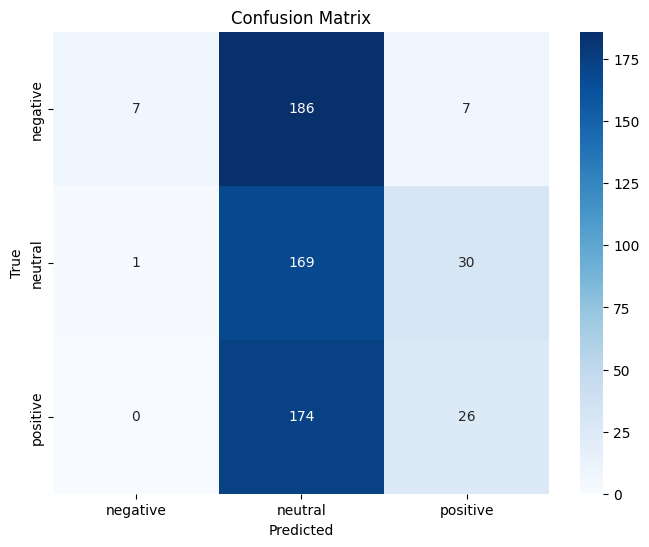

In [25]:
evaluate(y_test , y_pred)
# {'positive': 2, 'neutral': 1, 'none':1, 'negative': 0}

### **Notes: Why Increased Temperature Can Improve Accuracy**

While counter-intuitive for classification tasks, using sampling by setting **`do_sample=True`** and a non-zero **`temperature`** (e.g., 0.6) can sometimes increase model accuracy. This happens when the fine-tuned model is **well-calibrated but not perfectly ordered.**

The primary reason for this is that it allows the model to escape the **"greedy trap."**

* **Greedy Decoding (`do_sample=False`):** This method is deterministic and always chooses the single token with the absolute highest probability. If the model has a slight bias that consistently makes the wrong token the top choice (even by a small margin), greedy decoding will be wrong 100% of the time.

* **Sampling (`do_sample=True`):** This method introduces controlled randomness. The model now has a chance to pick the second or third most likely token. If the correct answer is frequently the model's second-best guess, giving it a chance to be chosen will increase the overall accuracy across the test set.

In essence, a bit of randomness can help overcome a model's minor biases, allowing it to select other high-confidence (and often correct) answers that would otherwise be ignored by a purely deterministic approach.

Accuracy: 0.337
Accuracy for label 0: 0.035
Accuracy for label 1: 0.845
Accuracy for label 2: 0.130

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.04      0.07       200
           1       0.32      0.84      0.46       200
           2       0.41      0.13      0.20       200

    accuracy                           0.34       600
   macro avg       0.54      0.34      0.24       600
weighted avg       0.54      0.34      0.24       600



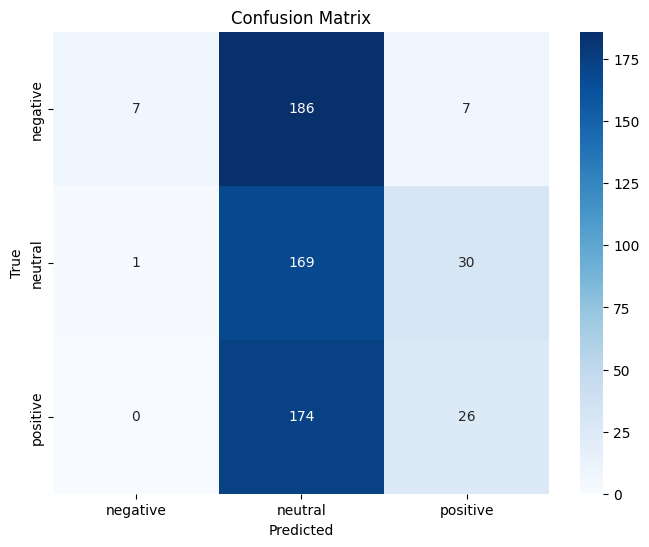

In [26]:
evaluate(y_test , y_pred)
# {'positive': 2, 'neutral': 1, 'none':1, 'negative': 0}

## Finetuning the Model

### **Notes: Understanding `per_device_train_batch_size = 1` and Gradient Accumulation**

This is a common and powerful strategy for fine-tuning large models on GPUs with limited memory (VRAM). It involves a trade-off between computation time and memory usage.

#### **1. The Problem: GPU Memory Limitation**

When training a neural network, the GPU must hold several components in its memory at once:
* The model's weights (even when quantized, this is significant).
* The optimizer states (e.g., for the AdamW optimizer).
* The activations and gradients for every example in the current batch.

The memory required for activations and gradients scales directly with the batch size. For large models like Phi-2, even with QLoRA optimizations, the memory needed to process just two examples (`batch_size=2`) at once can exceed the capacity of a typical 16 GB GPU, leading to a `CUDA out of memory` error.

#### **2. The Initial Solution: `per_device_train_batch_size = 1`**

By setting the batch size to 1, we ensure that the memory footprint of the forward and backward pass is as small as possible, allowing the training process to run without crashing.

* **The Drawback:** Training with a true batch size of 1 is not ideal. The weight updates become very "noisy" and unstable because each update is based on the information from only a single, potentially unrepresentative example. This can hinder the model's ability to learn effectively.

#### **3. The Real Solution: Gradient Accumulation**

To get the stability of a larger batch size while keeping memory usage low, we use **gradient accumulation**. This is controlled by the `gradient_accumulation_steps` parameter in `TrainingArguments`.

**How it Works:**

Instead of updating the model's weights after every single example, the trainer does the following:

1.  **Forward/Backward Pass:** It processes a single example (a "micro-batch") and calculates its gradients.
2.  **Accumulate:** It **stores these gradients** and does **not** update the model's weights.
3.  **Repeat:** It repeats steps 1 and 2 for the specified number of `gradient_accumulation_steps`. Each time, it adds the new gradients to the running sum of stored gradients.
4.  **Update:** Only after accumulating the gradients from multiple examples does the trainer perform **one single weight update** using the combined (averaged) gradient information.

**The result is an "effective batch size" larger than what the GPU could handle at once.**

> **Effective Batch Size = `per_device_train_batch_size` x `gradient_accumulation_steps`**

For example, if you have:
* `per_device_train_batch_size = 1`
* `gradient_accumulation_steps = 8`

...your GPU only ever sees **1** sample at a time, but the model's weights are updated based on the information from **8** samples, giving you the stable training benefits of a much larger batch.

This technique makes fine-tuning large models accessible on consumer hardware, with the only trade-off being that the training process takes longer to complete.

In [27]:
# Check GPU compatibility with bfloat16

"""Check GPU compatibility with bfloat16
This is useful if you are using 4-bit quantization with float16.
It is a version number used by CUDA to describe GPU architecture (e.g., Volta, Turing, Ampere).
For example, 7.x = Turing architecture (e.g., RTX 20xx, some Tesla cards).
"""
if compute_dtype == torch.float16 and use_4bits:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

## What is we set False to fp16 in This Script?
In this specific fine-tuning script, you are using QLoRA. The QLoRA process already involves its own advanced precision handling:

The base model is loaded in 4-bit precision (use_4bit = True).
The computations are handled using a specific data type set by bnb_4bit_compute_dtype = "float16".
Because the bitsandbytes library is already managing the low-precision storage (4-bit) and the computation precision (16-bit) as part of the QLoRA process, you do not need to enable the standard transformers trainer's mixed-precision flags. Setting them to False would be the correct approach here, as enabling them could conflict with the QLoRA settings.

The `max_seq_length` parameter controls the **maximum number of tokens** (not characters or words) that your model will process for each input example.

### How to choose a suitable `max_seq_length`:

#### 1. **Check your data**
- **Tokenize** a sample of your dataset and look at the distribution of token lengths.
- Set `max_seq_length` to cover most (e.g., 95–99%) of your samples, or as high as your GPU memory allows.

#### 2. **Model limitations**
- Each model has a maximum context window (e.g., 1024, 2048, or 4096 tokens). You cannot set `max_seq_length` higher than this.

#### 3. **Hardware constraints**
- Higher `max_seq_length` increases memory usage and training time.
- If you get out-of-memory errors, reduce `max_seq_length`.

#### 4. **Task requirements**
- For short texts (like sentiment analysis on sentences), 128–256 is often enough.
- For document-level tasks, you may need 512, 1024, or more.

---

### **How to check token lengths in your data:**


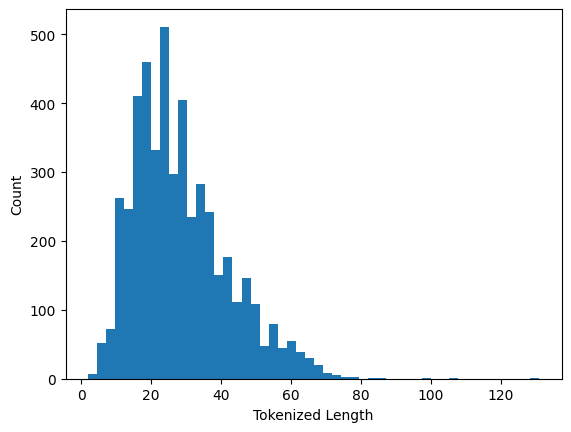

95th percentile: 55.0


In [28]:
# Example for Hugging Face tokenizer
lengths = [len(tokenizer.encode(text)) for text in df['text']]
import matplotlib.pyplot as plt
plt.hist(lengths, bins=50)
plt.xlabel("Tokenized Length")
plt.ylabel("Count")
plt.show()
print(f"95th percentile: {np.percentile(lengths, 95)}")

Set `max_seq_length` to the 95th or 99th percentile, or the model's max if lower.

---

**Summary:**  
Considering that 1024 is the optimal choice

### **1. `evaluation_strategy="epoch"`**

* **The setting `"epoch"`:** This specifically means: "At the end of every single epoch (one full pass through the training data), pause the training and run an evaluation on the separate evaluation dataset (`eval_data`)."
*(The alternative is `"steps"`, which would evaluate every N training steps instead of at the end of each epoch.)*

---

### **2. `save_strategy="epoch"`**

* **The setting `"epoch"`:** This specifically means: "At the end of every single epoch, save a complete copy of the model, tokenizer, and trainer state to a new folder (e.g., `checkpoint-100`, `checkpoint-200`, etc.)."
  
---

### **3. `load_best_model_at_end=True`**

* **The setting `True`:** This instructs the trainer: "Once all epochs are complete, look back at all the evaluation scores you calculated. Find the checkpoint that had the **best score** (e.g., the lowest evaluation loss or the highest evaluation accuracy), and automatically load the weights from that specific checkpoint back into the final model."

In [29]:
# output_dir = "/content/drive/MyDrive/Machine Learning/Finetuning/trained_weights_phi2/trained_weights"
output_dir = "trained_weights"

peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0.1,
        r=64,
        bias="none",
        target_modules="all-linear",
        task_type="CAUSAL_LM",
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=5,                       # number of training epochs
    per_device_train_batch_size=1,            # batch size per device during training
    gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    save_steps=0,                             # The frequency for saving model checkpoints.
    logging_steps=25,                         # log every 10 steps
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=True,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    report_to="tensorboard",                  # report metrics to tensorboard
    eval_strategy="epoch",
    save_strategy="epoch",                    # save checkpoint every epoch
    load_best_model_at_end=True
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    # dataset_text_field="text",         # In the new updates this field is set by default, if has different name then set by SFTConfig
    processing_class=tokenizer
)

Adding EOS to train dataset:   0%|          | 0/1200 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1200 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1200 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/4246 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/4246 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/4246 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [30]:
# Train model
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.115600,1.239969
2,0.933100,1.186872
3,0.891100,1.168967
4,0.766400,1.176548
5,0.716400,1.185248


TrainOutput(global_step=750, training_loss=1.0665988337198893, metrics={'train_runtime': 4870.9185, 'train_samples_per_second': 1.232, 'train_steps_per_second': 0.154, 'total_flos': 6850437161779200.0, 'train_loss': 1.0665988337198893})

The model and the tokenizer are saved to disk for later usage.



In [31]:
# Save trained model and tokenizer
trainer.save_model()
tokenizer.save_pretrained(output_dir)

('trained_weights/tokenizer_config.json',
 'trained_weights/special_tokens_map.json',
 'trained_weights/vocab.json',
 'trained_weights/merges.txt',
 'trained_weights/added_tokens.json',
 'trained_weights/tokenizer.json')